In [1]:
%load_ext autoreload
%autoreload 2

# STEPS THAT I WOULD FOLLOW TO SOLVE THE CHALLENGE

## 1. Plot the given graph

Let us imagine that we want to color a $N = 4$ nodes graph with the following edges:
$(0,1), (0,2), (1, 2),$ and $(2, 3)$

With $k = 3$ colors.

In [2]:
k = 3
N = 4

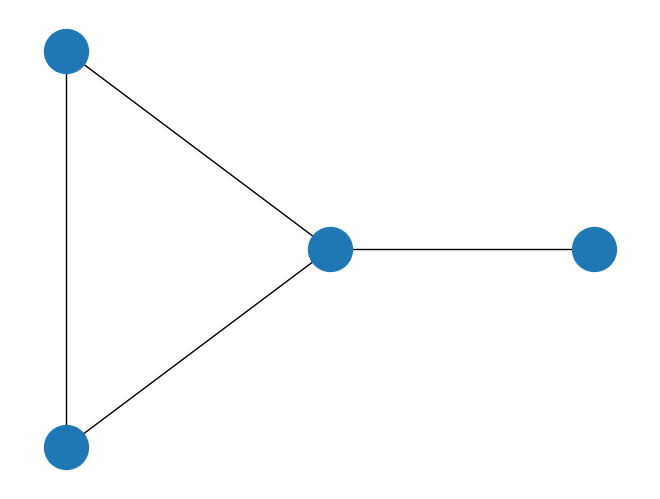

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
g = nx.Graph()
g.add_edge(0, 1)
g.add_edge(0, 2)
g.add_edge(1, 2)
g.add_edge(2, 3)
nx.draw(g, {0: (0, 0), 1: (0, 2), 2: (1, 1), 3: (2, 1)}, node_size=1000)
plt.show()

## 2. Get a the QUBO problem

### 2.1. Encode the problem as a graph of $n = k N$ nodes and find the QUBO 

The cost function of the QUBO looks like:

$$ f(\vec x) = \sum_i^n \sum_j^n Q_{ij} x_ix_j,$$

If one looks (for a while) at the given cost function:

$$ f(\vec x) = 
A \sum_v^N(1 - \sum_{i=1}^{k} x_{v,i})^2 + A \sum_{(uv) \in E} \sum_{i=1}^{k} x_{u,i}x_{v,i}
$$

It can be seen that:
$$
Q_{ijuv} = \left \{ 
\begin{array}{c}
         -A &\quad i= j\text{ and }u= v  \\  
\,\,\,\,  A &\quad i= j\text{ and }u\neq v  \\
\,\,\,\,  A &\quad i\neq j\text{ and }u= v  \\  
\,\,\,\,  0 &\quad i\neq j\text{ and }u\neq v  
\end{array}       
\right .
$$

To make it a little more clear, one can define new indices, for example: $q=u*k + i$, which leads to:
$$
Q_{qr} = \left \{ 
\begin{array}{cl}
         -A &\quad q= r  \\
\,\,\,\,  A &\quad q \text{ mod } k = r \text{ mod } k \\
\,\,\,\,  A &\quad q - (q \text{ mod } k) = r - (r \text{ mod } k)  \\
\,\,\,\,  0 &\quad \text{otherwise}  
\end{array}       
\right .
$$


### 2.2. Visualize the resulting problem (it could be useful to draw that by hand before 2.1.)

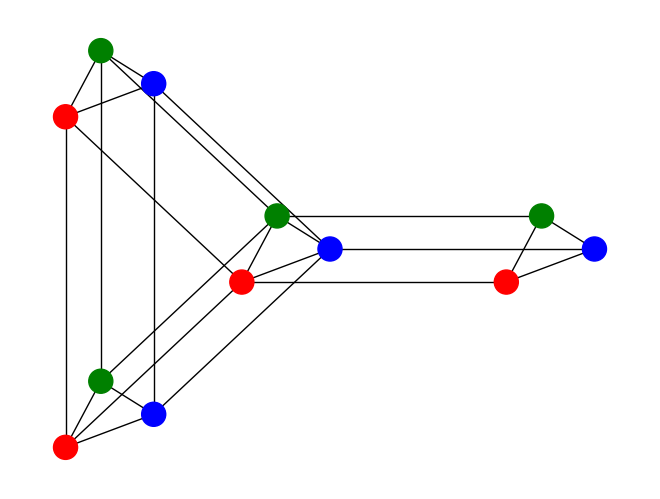

In [4]:
g2 = nx.Graph()
initial_edges = [(0, 1), (0, 2), (1, 2), (2, 3)]
q = lambda u, i: u*k + i
for u in range(N):
    for i in range(k):
        for j in range(k):
            if i != j:
                g2.add_edge(q(u, i), q(u, j))

new_edges = [ (q(u, i), q(v, i)) for u, v in initial_edges for i in range(k)]
g2.add_edges_from(new_edges)
pos = {0: (0, 0), 1: (0, 2), 2: (2, 1), 3: (5, 1)}
new_pos = {q(u, i): (pos[u][0] + i*0.2**(i-1), pos[u][1]+ i*0.2) for u in range(N) for i in range(k)}
colors = ['red', 'blue', 'green', 'yellow']
nx.draw(g2, new_pos, node_color= [colors[i] for _ in range(N) for i in range(k)])
plt.show()

The edges between nodes of the same color try not to have the same color in adjacent nodes

and edges between nodes of different color try not to have more than one color in each problem node

Remember here each problem node has been mapped to $k$ nodes in a new graph

## 3. Code the `graph_coloring_qubo` function

Now that we know how to create the $Q$ matrix we can create the QUBO object.

And we will get the cost function of a QUBO problem in the Ising encoding (we need that one to create the QUBO object):

$$ f(\vec s) = \sum_{\langle i\,j\rangle}J_{ij} s_is_j \,+\, \sum_i^n h_i s_i,$$ 

Thanks to this relation:

$$ \begin{array}{c}
J_{ij} = \frac{1}{4}Q_{ij} \quad \quad J_{ii} = 0  \\
 \\
h_i = - \frac{1}{2}Q_{ii} - \frac{1}{4} \sum_{ \substack{j=0 \\ j\neq i}}^nQ_{ij}
\end{array}$$

In [5]:
from openqaoa.problems import QUBO
import numpy as np

def graph_coloring_qubo(G, k, A=10) -> QUBO:
    """
    Returns the QUBO encoding of the graph coloring problem.
    
    Parameters
    ----------
    G: networkx.Graph
        The graph to be colored.
    k: int
        The number of colors to be used.
    A: float
        The weight of the terms

    Returns
    -------
    Q: dict
        The QUBO encoding of the graph coloring problem.
    """

    n_nodes = G.number_of_nodes()
    new_n_nodes = k*n_nodes

    j = lambda v,i: v*k + i # j(v,i) is the index of the new nodes corresponding to the old node v and color i

    # create matrix Q
    matrix_Q = np.zeros((new_n_nodes, new_n_nodes))
    for u, v in g.edges():
        for i in range(k):
            matrix_Q[j(u, i), j(v, i)] += A
            matrix_Q[j(v, i), j(u, i)] += A

    for u in g.nodes():
        for i, ii in nx.generators.complete_graph(n=k).edges():
            matrix_Q[j(u, i), j(u, ii)] += A
            matrix_Q[j(u, ii), j(u, i)] += A

    for u in g.nodes():
        for i in range(k):
            matrix_Q[j(u, i), j(u, i)] -= A
            
    # transform Q to J and h (bits to Ising)
    matrix_J = np.zeros((new_n_nodes, new_n_nodes))
    list_h = np.zeros(new_n_nodes)
    for i in range(new_n_nodes): 

        list_h[i] = - (matrix_Q[i, i] + sum([matrix_Q[i, j] for j in range(new_n_nodes)])) / 4

        for j in range(new_n_nodes):
            if i != j:
                matrix_J[i,j] = matrix_Q[i, j] / 4

    # get the terms and weights of the QUBO object
    terms = []
    weights = []

    for i in range(new_n_nodes):

        terms.append([i])
        weights.append(list_h[i])

        for j in range(i+1, new_n_nodes):
            if matrix_J[i,j] != 0:
                terms.append([i, j])
                weights.append(matrix_J[i,j])

    #return the QUBO object
    return QUBO(new_n_nodes, terms, weights)

## 4. Get the QUBO object of the problem

In [6]:
gc_qubo = graph_coloring_qubo(g, k)

In [7]:
gc_qubo.asdict()

{'terms': [[0],
  [0, 1],
  [0, 2],
  [0, 3],
  [0, 6],
  [1],
  [1, 2],
  [1, 4],
  [1, 7],
  [2],
  [2, 5],
  [8, 2],
  [3],
  [3, 4],
  [3, 5],
  [3, 6],
  [4],
  [4, 5],
  [4, 7],
  [5],
  [8, 5],
  [6],
  [6, 7],
  [8, 6],
  [9, 6],
  [7],
  [8, 7],
  [10, 7],
  [8],
  [8, 11],
  [9],
  [9, 10],
  [9, 11],
  [10],
  [10, 11],
  [11]],
 'weights': [-5.0,
  2.5,
  2.5,
  2.5,
  2.5,
  -5.0,
  2.5,
  2.5,
  2.5,
  -5.0,
  2.5,
  2.5,
  -5.0,
  2.5,
  2.5,
  2.5,
  -5.0,
  2.5,
  2.5,
  -5.0,
  2.5,
  -7.5,
  2.5,
  2.5,
  2.5,
  -7.5,
  2.5,
  2.5,
  -7.5,
  2.5,
  -2.5,
  2.5,
  2.5,
  -2.5,
  2.5,
  -2.5],
 'constant': 0,
 'n': 12,
 'problem_instance': {'problem_type': 'generic_qubo'},
 'metadata': {}}

## 5. Solve the problem classically

In [8]:
from openqaoa.utilities import ground_state_hamiltonian
cl_energy, cl_solutions_bitstrings = ground_state_hamiltonian(gc_qubo.hamiltonian)

In [9]:
print(f'Classical energy: {cl_energy}')
print(f'Classical solutions: {cl_solutions_bitstrings}')

Classical energy: -40.0
Classical solutions: ['001100010100', '100001010100', '010100001100', '100010001100', '001010100010', '010001100010', '010100001010', '100010001010', '010100001110', '100010001110', '001010100001', '010001100001', '001100010001', '100001010001', '001100010101', '100001010101', '001010100011', '010001100011']


This solutions are hard to read since we have mapped one node to $k$ nodes, let's write some function that returns a string $x=x_0x_1...x_N$, where $x_i \in \{0,1,...,k-1\}$

In [10]:
## FUNCTIONS THAT WILL BE USEFUL TO DRAW THE RESULTS

def generate_bitstrings(n):
    """
    This function generates all possible bitstrings of length n.

    Parameters:
    n: int
        the length of the bitstrings to generate

    Returns:
        A list of all possible bitstrings of length n.
    """
    bitstrings = []
    for i in range(2**n):
        bitstrings.append(bin(i)[2:].zfill(n))
    return bitstrings

def binary_to_knary(bitstr, k):
    """
    Converts a bitstr to a k-nary number of length len(x)/k. 
    Example: binary_to_knary('001001100010', k=3) = '2201'  

    Parameters
    ----------
    bitstr: str
        The binary number to be converted.
    k: int
        Number of colors.

    Returns
    -------
    knary: str
    """
    assert len(bitstr) % k == 0, "len(bitstr) must be a multiple of k"
    n = len(bitstr)//k

    binary_colors = dict(zip(['0'*(k-i-1) + '1' + '0'*i for i in range(k)], range(k)))
    binary_colors = {bitstr: 'x' if not bitstr in binary_colors else binary_colors[bitstr] for bitstr in generate_bitstrings(k)}

    return ''.join([str(binary_colors[bitstr[i*k:(i+1)*k]]) for i in range(n)])

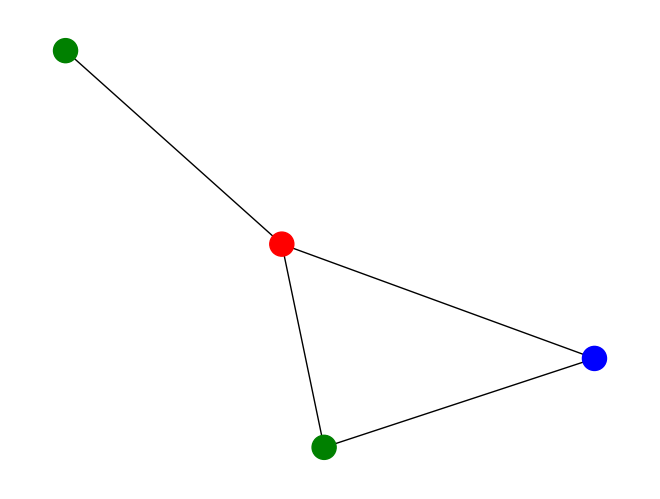

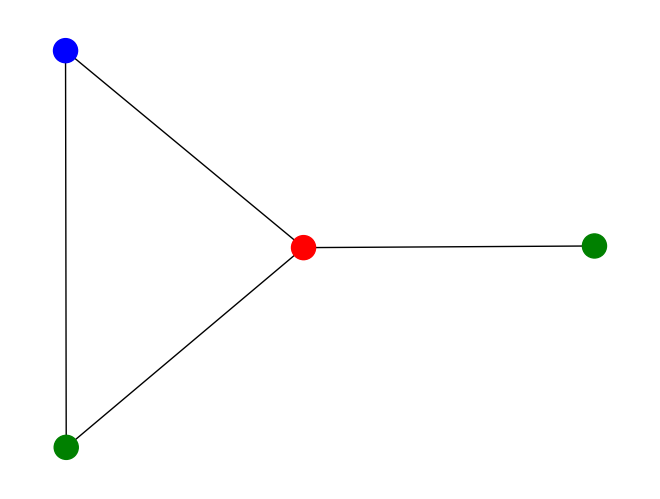

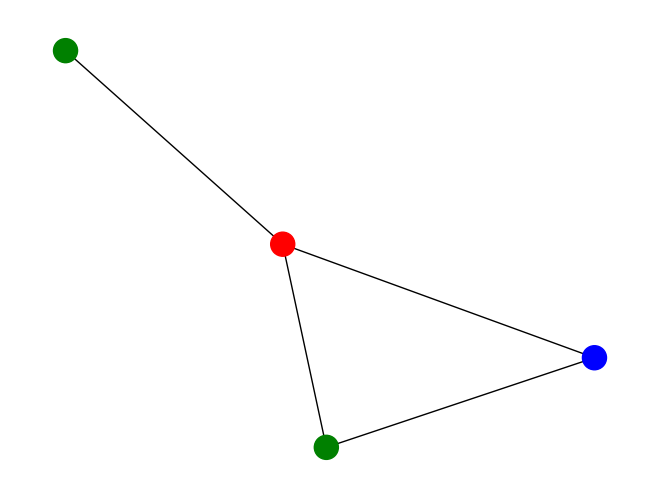

In [11]:
color_map = {   
    '0': 'blue', 
    '1': 'red', 
    '2': 'green',
    '3': 'orange',
    '4': 'purple',
    '5': 'brown',
    '6': 'pink',
    '7': 'gray',
    '8': 'olive',
    '9': 'cyan', 
    'x': 'black'}

for i, solution in enumerate(cl_solutions_bitstrings):
    solution = binary_to_knary(cl_solutions_bitstrings[0], k)
    node_colors = {node: color_map[color] for node, color in zip(set(g.nodes()), solution)}
    nx.draw(g, node_color=[node_colors[node] for node in g.nodes()])
    plt.show()

    if i == 2: break # plot just 3 graphs

## 6. Solve the problem with QAOA in a Quantum Simulator

In [12]:
from openqaoa import QAOA

q = QAOA()
q.compile(gc_qubo)
q.optimize()

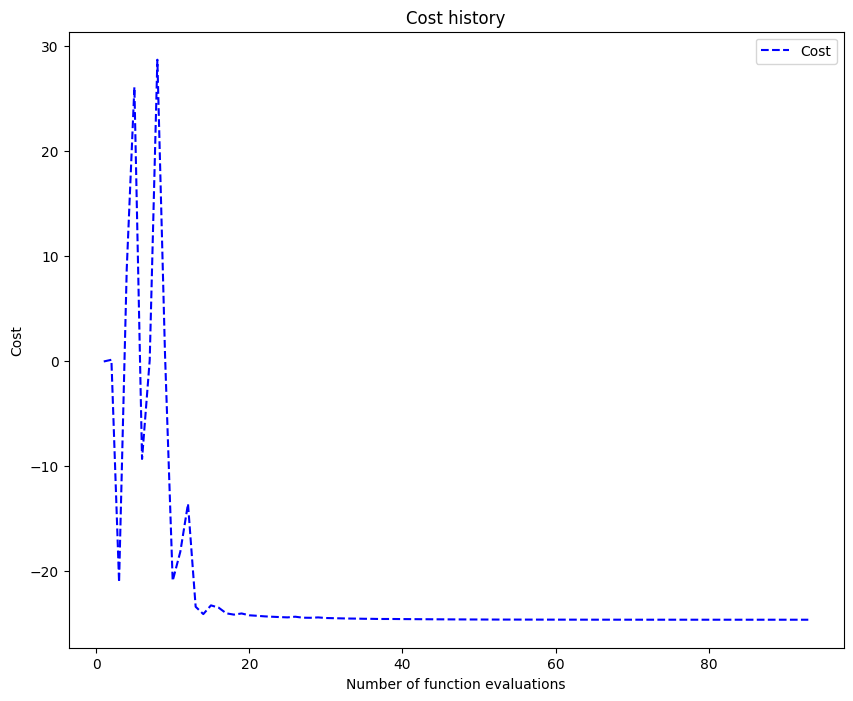

In [13]:
q.results.plot_cost()

In [14]:
q.results.optimized

{'angles': [0.41411618349, 1.319856508624],
 'cost': -24.685397474466,
 'measurement_outcomes': array([ 3.41907663e-03+2.28531832e-02j,  2.13990093e-02+1.72110374e-02j,
         2.13990093e-02+1.72110374e-02j, ...,
        -1.97850313e-04-1.05263164e-04j, -1.97850313e-04-1.05263164e-04j,
        -7.88548985e-05+8.90963946e-05j]),
 'job_id': '973b306c-d424-4ede-9de7-4536738b0615',
 'eval_number': 92}

In [15]:
solutions_bitstrings, energy = q.results.most_probable_states.values()
solutions = [binary_to_knary(bitstr, k) for bitstr in solutions_bitstrings]

In [16]:
print(f'energy: {energy}')
print(f'solutions: {solutions}')

energy: -40.0
solutions: ['0212', '2012', '1202', '2102', '0121', '1021', '1201', '2101', '0120', '1020', '0210', '2010']


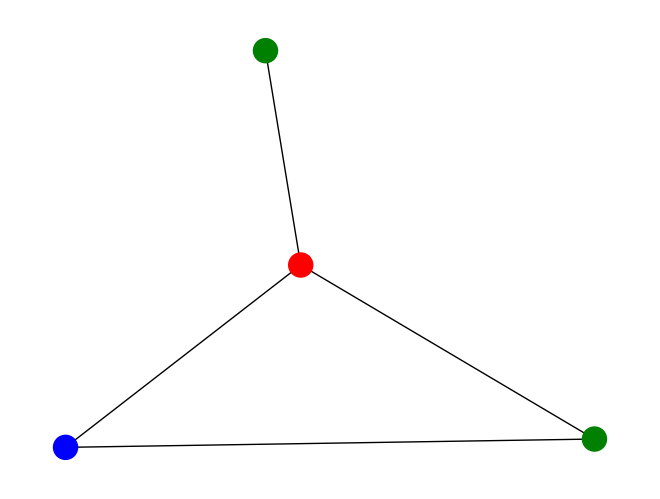

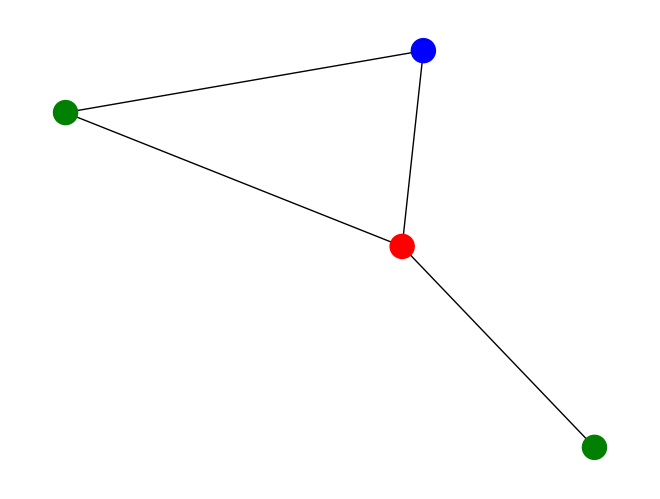

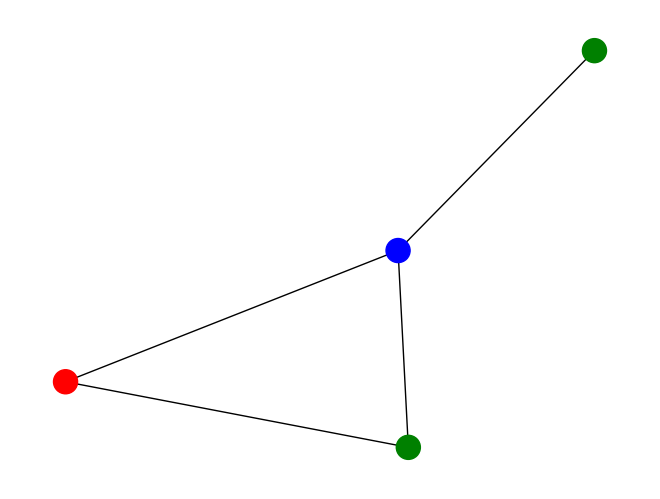

In [17]:
# Draw the graph with the assigned node colors
for i, each in enumerate(solutions):
    node_colors = {node: color_map[color] for node, color in zip(set(g.nodes()), each)}
    nx.draw(g, node_color=[node_colors[node] for node in g.nodes()])
    plt.show()

    if i == 2: break #just show 3 graphs

## 7. Run different problems

In [18]:
def coloring_with_qaoa(graph, k=2):
    # get qubo
    gc_qubo = graph_coloring_qubo(graph, k=k)

    # check classical solutions
    cl_energy, cl_solutions_bitstrings = ground_state_hamiltonian(gc_qubo.hamiltonian)
    print(f'Classical energy: {cl_energy}')
    print(f'Classical solutions: {cl_solutions_bitstrings}')

    # run qaoa
    q = QAOA()
    q.compile(gc_qubo)
    q.optimize()

    # get results
    solutions_bitstrings, energy = q.results.most_probable_states.values()
    solutions = [binary_to_knary(bitstr, k) for bitstr in solutions_bitstrings]
    print(f'energy: {energy}')
    print(f'solutions: {solutions}')

    # plot 
    for i, each in enumerate(solutions):
        node_colors = {node: color_map[color] for node, color in zip(set(g.nodes()), each)}
        nx.draw(g, node_color=[node_colors[node] for node in g.nodes()])
        plt.show()

        if i == 1: break #just show 2 graphs

Classical energy: -60.0
Classical solutions: ['0010100001001000', '0001100001001000', '0011100001001000', '1000001001001000', '0001001001001000', '1001001001001000', '0001101001001000', '1000000101001000', '0010000101001000', '1010000101001000', '0010100101001000', '1000001101001000', '0100100000101000', '0001100000101000', '0101100000101000', '1000010000101000', '0001010000101000', '1001010000101000', '0001110000101000', '1000000100101000', '0100000100101000', '1100000100101000', '0100100100101000', '1000010100101000', '0001100001101000', '1000000101101000', '0100100000011000', '0010100000011000', '0110100000011000', '1000010000011000', '0010010000011000', '1010010000011000', '0010110000011000', '1000001000011000', '0100001000011000', '1100001000011000', '0100101000011000', '1000011000011000', '0010100001011000', '1000001001011000', '0100100000111000', '1000010000111000', '0010010010000100', '0001010010000100', '0011010010000100', '0100001010000100', '0001001010000100', '0101001010000

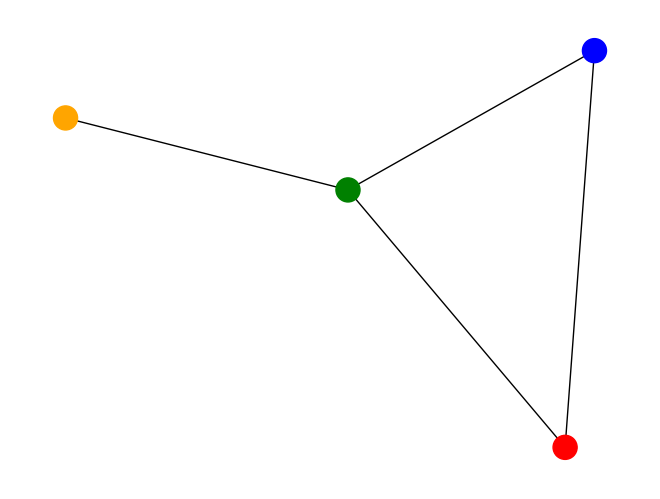

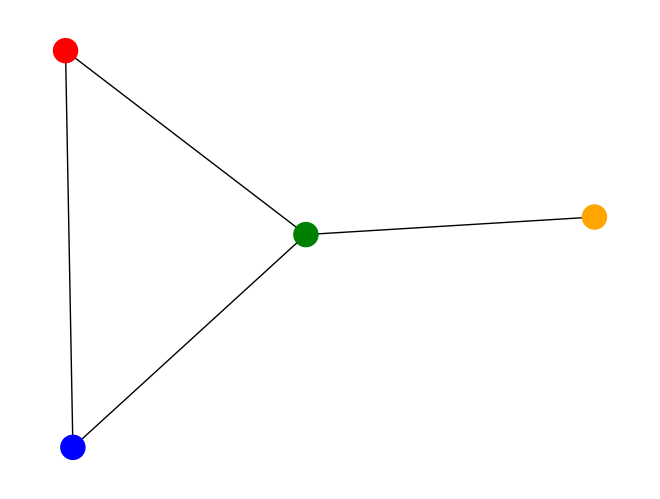

In [19]:
# solve the last problem but with 4 colors
coloring_with_qaoa(g, k=4)

Classical energy: -25.0
Classical solutions: ['01101010', '10010101']
energy: -25.0
solutions: ['0111', '1000']


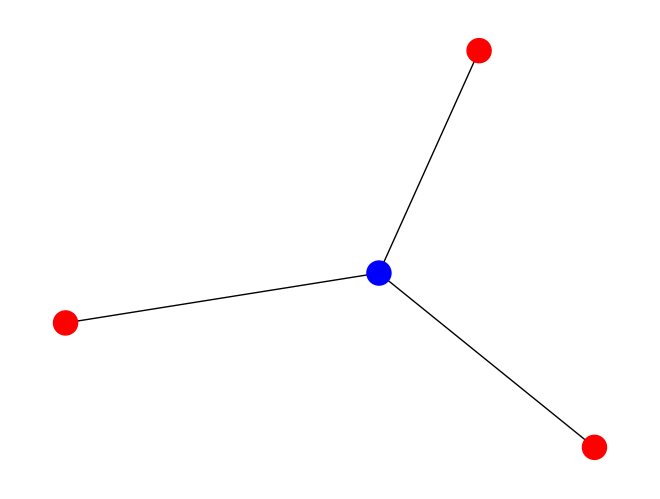

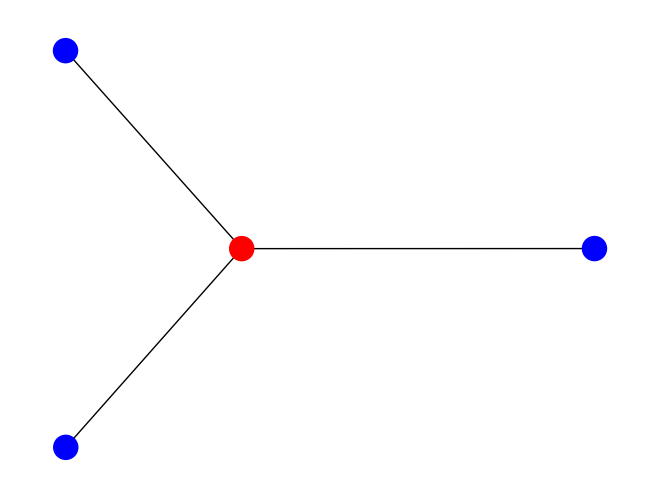

In [20]:
g = nx.Graph()
g.add_edges_from([ (0,1),(0,2),(0,3) ])
coloring_with_qaoa(g, k=2)

Classical energy: -105.0
Classical solutions: ['001010100001010100', '010001100010001100', '001100010001100010', '100001010100001010', '010100001010100001', '100010001100010001']
energy: -105.0
solutions: ['012012', '102102', '021021', '201201', '120120', '210210']


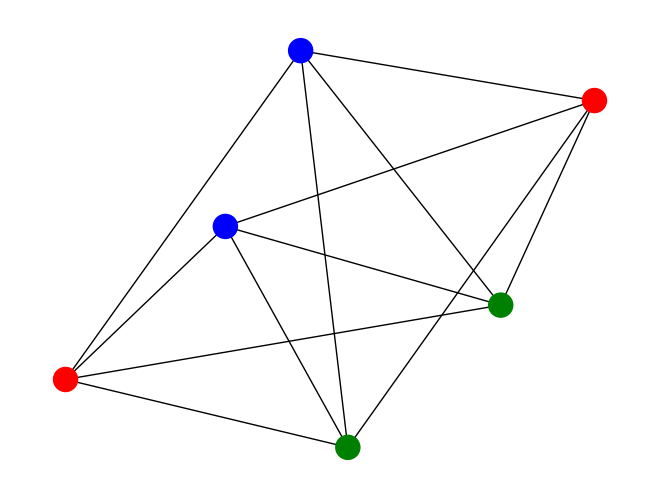

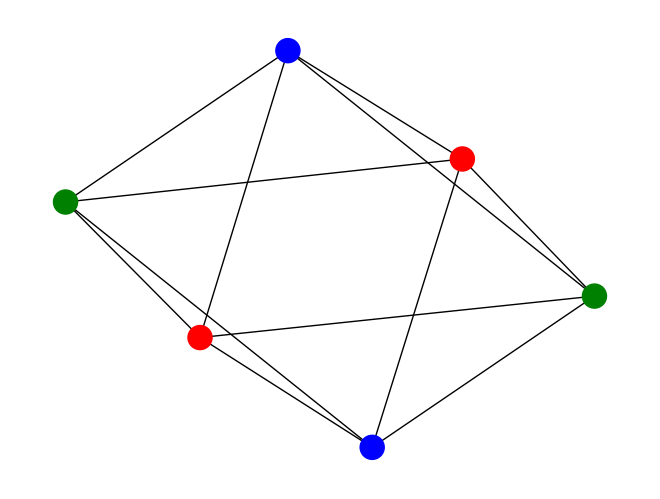

In [21]:
g = nx.Graph()
g.add_edges_from([
                    (0,1), (0,2), (0,4), (0,5), 
                    (1,2), (1,3), (1,5),
                    (2,3), (2,4), 
                    (3,4), (3,5),
                    (4,5) 
                ])

coloring_with_qaoa(g, k=3)

Classical energy: -107.5
Classical solutions: ['001010100010100010100', '010001100001100001100', '001100010100010100010', '100001010001010001010', '010100001100001100001', '100010001010001010001']
energy: -97.5
solutions: ['x012012', 'x102102', 'x021021', 'x201201', 'x120120', 'x210210']


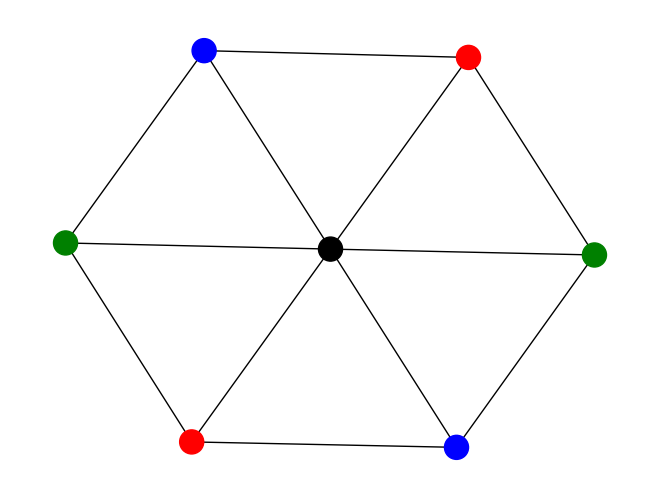

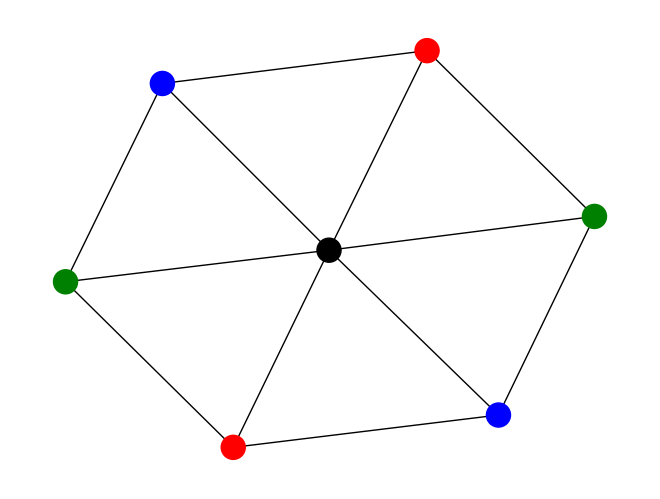

In [22]:
g = nx.Graph()
g.add_edges_from([
                    (0,1), (0,2), (0,3), (0,4), (0,5), (0,6),
                    (1,2), (2,3), (3,4), (4,5), (5,6), (6,1)
                ])

coloring_with_qaoa(g, k=3)

## 8. Play with QAOA

For this last graph we haven't found the optimal solution, one could play with QAOA, change $p$, type of parameters, initialization, etc.. 